In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats.distributions as dist
import seaborn as sns

# 1. Load Data and Clean

### 1.1 Load

In [2]:
df = pd.read_parquet('full_table.parquet')
df.head()

personid                           encounterid  \
0  000946f4-8ed9-4086-949d-8058fd7f7e4f  88d73329-83ac-4eb6-9329-6efe055c7a9d   
1  000a569a-5d0d-40e0-b620-fdcf8e1ac9ae  9171c764-e306-4870-ba92-4982094fc59c   
2  000b03a4-8ff0-47e5-80a6-4e87aa66dcd4  6c184f98-65ff-42d0-9d90-2a63e75df024   
3  000f27f5-9768-42ae-85f4-cc339dbc642a  24f99422-3611-48bb-a2d2-bdb767ad8a6f   
4  000f27f5-9768-42ae-85f4-cc339dbc642a  85384f2c-f3cd-46ed-bc91-6d0356d5c4ad   

   MDRO1  MDRO2         servicedate       dischargedate        LOS        DOD  \
0    0.0    0.0 2020-09-11 22:04:00 2020-10-08 00:30:00  26.101389 2020-10-07   
1    0.0    0.0 2021-06-05 03:27:00 2021-06-10 23:34:00   5.838194        NaT   
2    0.0    0.0 2021-07-01 07:28:44 2021-07-08 23:10:00   7.653657        NaT   
3    1.0    1.0 2016-01-10 08:56:00 2016-02-04 00:10:00  24.634722        NaT   
4    0.0    0.0 2015-12-07 18:13:00 2015-12-16 23:43:00   9.229167        NaT   

   Mortality  time_to_death_timestamp  ...  sodium  serum_albumin  Female  \
0        1.0                25.080556  ...     NaN            NaN     NaN   
1        0.0                      NaN  ...     NaN            NaN     NaN   
2        0.0                      NaN  ...     NaN            NaN     NaN   
3        0.0                      NaN  ...     NaN            NaN     NaN   
4        0.0                      NaN  ...     NaN            NaN     NaN   

   MELD  MELD_group  cp_pro_rated  cp_original  ACLF  hospice  nosocomial  
0   NaN        None     15.000000          NaN   3.0        0           0  
1   NaN        None      8.333333          NaN   3.0        0           0  
2   NaN        None      8.750000          NaN   3.0        0           0  
3   NaN        None     11.666667          NaN   3.0        0           0  
4   NaN        None     11.666667          NaN   3.0        0           0  

[5 rows x 82 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12570 entries, 0 to 12569
Data columns (total 82 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   personid                 12570 non-null  object        
 1   encounterid              12570 non-null  object        
 2   MDRO1                    12570 non-null  float64       
 3   MDRO2                    12570 non-null  float64       
 4   servicedate              12570 non-null  datetime64[ns]
 5   dischargedate            12570 non-null  datetime64[ns]
 6   LOS                      12570 non-null  float64       
 7   DOD                      2229 non-null   datetime64[ns]
 8   Mortality                12570 non-null  float64       
 9   time_to_death_timestamp  2229 non-null   float64       
 10  time_to_death_date       2229 non-null   float64       
 11  ALB_diff_hour            12570 non-null  float64       
 12  albumin                  12570 n

### 1.2 Select Variables of interest

In [4]:
df_2 = df[['personid', 'encounterid', 'MDRO1', 'LOS', 'albumin', 'ICU', 'AKI', 'Region', 'bed_size', 'tenant', 'Index_Year',
           'HRS', 'HE', 'Age', 'Age_Group', 'Gender', 'Race', 'Payor', 'MELD', 'cp_pro_rated', 'Mortality']]
df_2.head()

personid                           encounterid  \
0  000946f4-8ed9-4086-949d-8058fd7f7e4f  88d73329-83ac-4eb6-9329-6efe055c7a9d   
1  000a569a-5d0d-40e0-b620-fdcf8e1ac9ae  9171c764-e306-4870-ba92-4982094fc59c   
2  000b03a4-8ff0-47e5-80a6-4e87aa66dcd4  6c184f98-65ff-42d0-9d90-2a63e75df024   
3  000f27f5-9768-42ae-85f4-cc339dbc642a  24f99422-3611-48bb-a2d2-bdb767ad8a6f   
4  000f27f5-9768-42ae-85f4-cc339dbc642a  85384f2c-f3cd-46ed-bc91-6d0356d5c4ad   

   MDRO1        LOS  albumin  ICU  AKI   Region bed_size  tenant  ...  HRS  \
0    0.0  26.101389        1  1.0  1.0    South   >=1000    65.0  ...    0   
1    0.0   5.838194        1  0.0  0.0     West   >=1000     7.0  ...    1   
2    0.0   7.653657        0  0.0  1.0  Midwest  300-499     9.0  ...    0   
3    1.0  24.634722        1  0.0  0.0     West   >=1000    63.0  ...    0   
4    0.0   9.229167        1  0.0  0.0     West   >=1000    63.0  ...    0   

   HE   Age  Age_Group  Gender   Race     Payor MELD  cp_pro_rated  Mortality  
0   0  36.0        1.0    Male  White      Self  NaN     15.000000        1.0  
1   0  44.0        1.0    Male  White   Unknown  NaN      8.333333        0.0  
2   0  70.0        4.0  Female  White  Medicare  NaN      8.750000        0.0  
3   0  50.0        2.0    Male  White  Medicaid  NaN     11.666667        0.0  
4   0  50.0        2.0    Male  White  Medicaid  NaN     11.666667        0.0  

[5 rows x 21 columns]

In [5]:
df_2.shape

(12570, 21)

### 1.3 Drop Missing Rows

In [6]:
df_2 = df_2.dropna()
df_2.head()

personid  \
7   0017bb37-317e-41a6-bef7-01b7840fa845   
9   001ef405-5d5f-4625-9836-7a2672f12114   
16  00443f43-e530-41e5-af8a-14140bd6ba68   
20  0078e7c2-2e5c-454e-b8f7-c1624ebdf2d5   
21  007b52cd-8610-483f-b838-d2bfdd803898   

                             encounterid  MDRO1        LOS  albumin  ICU  AKI  \
7   bf6e4e08-dccc-4004-8749-6d9fb4e4f756    0.0   2.626389        1  0.0  1.0   
9   2f0df976-3da1-414e-9d68-f18baeebfa5d    0.0   4.181250        1  0.0  0.0   
16  60fd246e-7745-466a-abe8-052e994b1cf7    0.0   1.904167        1  0.0  0.0   
20  67914502-a5ef-4eda-a88b-4692a376f7bf    1.0  72.888194        1  0.0  1.0   
21  a8aea38c-fe45-4926-bd77-601240987560    0.0  23.989583        1  0.0  1.0   

       Region bed_size  tenant  ...  HRS  HE   Age  Age_Group  Gender  \
7        West   >=1000    68.0  ...    0   0  55.0        2.0  Female   
9        West  500-999    48.0  ...    0   0  48.0        1.0    Male   
16       West   >=1000    63.0  ...    0   0  41.0        1.0    Male   
20  Northeast  500-999   108.0  ...    0   0  60.0        3.0  Female   
21  Northeast  500-999    31.0  ...    0   0  59.0        3.0    Male   

       Race       Payor  MELD  cp_pro_rated  Mortality  
7     White    Medicaid  18.0      6.000000        1.0  
9   Unknown     Unknown  28.0     11.000000        0.0  
16    White    Medicaid  24.0     12.000000        0.0  
20    White  Commercial  16.0     11.000000        0.0  
21  Unknown    Medicaid  19.0      8.333333        0.0  

[5 rows x 21 columns]

In [7]:
df_2.shape

(4945, 21)

### 1.4 Clean Variables

#### Gender

In [8]:
df_2['Gender'].value_counts()

Male      3093
Female    1839
Other       13
Name: Gender, dtype: int64

In [9]:
df_2 = df_2.loc[df_2['Gender'].isin(('Male', 'Female'))]
df_2.head()

personid  \
7   0017bb37-317e-41a6-bef7-01b7840fa845   
9   001ef405-5d5f-4625-9836-7a2672f12114   
16  00443f43-e530-41e5-af8a-14140bd6ba68   
20  0078e7c2-2e5c-454e-b8f7-c1624ebdf2d5   
21  007b52cd-8610-483f-b838-d2bfdd803898   

                             encounterid  MDRO1        LOS  albumin  ICU  AKI  \
7   bf6e4e08-dccc-4004-8749-6d9fb4e4f756    0.0   2.626389        1  0.0  1.0   
9   2f0df976-3da1-414e-9d68-f18baeebfa5d    0.0   4.181250        1  0.0  0.0   
16  60fd246e-7745-466a-abe8-052e994b1cf7    0.0   1.904167        1  0.0  0.0   
20  67914502-a5ef-4eda-a88b-4692a376f7bf    1.0  72.888194        1  0.0  1.0   
21  a8aea38c-fe45-4926-bd77-601240987560    0.0  23.989583        1  0.0  1.0   

       Region bed_size  tenant  ...  HRS  HE   Age  Age_Group  Gender  \
7        West   >=1000    68.0  ...    0   0  55.0        2.0  Female   
9        West  500-999    48.0  ...    0   0  48.0        1.0    Male   
16       West   >=1000    63.0  ...    0   0  41.0        1.0    Male   
20  Northeast  500-999   108.0  ...    0   0  60.0        3.0  Female   
21  Northeast  500-999    31.0  ...    0   0  59.0        3.0    Male   

       Race       Payor  MELD  cp_pro_rated  Mortality  
7     White    Medicaid  18.0      6.000000        1.0  
9   Unknown     Unknown  28.0     11.000000        0.0  
16    White    Medicaid  24.0     12.000000        0.0  
20    White  Commercial  16.0     11.000000        0.0  
21  Unknown    Medicaid  19.0      8.333333        0.0  

[5 rows x 21 columns]

In [10]:
df_2['female'] = np.where(df_2['Gender']=='Female', 1, 0)
df_2 = df_2.drop('Gender', axis=1)
df_2.head()

personid  \
7   0017bb37-317e-41a6-bef7-01b7840fa845   
9   001ef405-5d5f-4625-9836-7a2672f12114   
16  00443f43-e530-41e5-af8a-14140bd6ba68   
20  0078e7c2-2e5c-454e-b8f7-c1624ebdf2d5   
21  007b52cd-8610-483f-b838-d2bfdd803898   

                             encounterid  MDRO1        LOS  albumin  ICU  AKI  \
7   bf6e4e08-dccc-4004-8749-6d9fb4e4f756    0.0   2.626389        1  0.0  1.0   
9   2f0df976-3da1-414e-9d68-f18baeebfa5d    0.0   4.181250        1  0.0  0.0   
16  60fd246e-7745-466a-abe8-052e994b1cf7    0.0   1.904167        1  0.0  0.0   
20  67914502-a5ef-4eda-a88b-4692a376f7bf    1.0  72.888194        1  0.0  1.0   
21  a8aea38c-fe45-4926-bd77-601240987560    0.0  23.989583        1  0.0  1.0   

       Region bed_size  tenant  ...  HRS  HE   Age  Age_Group     Race  \
7        West   >=1000    68.0  ...    0   0  55.0        2.0    White   
9        West  500-999    48.0  ...    0   0  48.0        1.0  Unknown   
16       West   >=1000    63.0  ...    0   0  41.0        1.0    White   
20  Northeast  500-999   108.0  ...    0   0  60.0        3.0    White   
21  Northeast  500-999    31.0  ...    0   0  59.0        3.0  Unknown   

         Payor  MELD  cp_pro_rated  Mortality  female  
7     Medicaid  18.0      6.000000        1.0       1  
9      Unknown  28.0     11.000000        0.0       0  
16    Medicaid  24.0     12.000000        0.0       0  
20  Commercial  16.0     11.000000        0.0       1  
21    Medicaid  19.0      8.333333        0.0       0  

[5 rows x 21 columns]

#### MELD

In [11]:
df_2['MELD_tertiles'] = pd.qcut(df_2['MELD'], q=3, labels=['Tertile 1', 'Tertile 2', 'Tertile 3'])
df_2.head()

personid  \
7   0017bb37-317e-41a6-bef7-01b7840fa845   
9   001ef405-5d5f-4625-9836-7a2672f12114   
16  00443f43-e530-41e5-af8a-14140bd6ba68   
20  0078e7c2-2e5c-454e-b8f7-c1624ebdf2d5   
21  007b52cd-8610-483f-b838-d2bfdd803898   

                             encounterid  MDRO1        LOS  albumin  ICU  AKI  \
7   bf6e4e08-dccc-4004-8749-6d9fb4e4f756    0.0   2.626389        1  0.0  1.0   
9   2f0df976-3da1-414e-9d68-f18baeebfa5d    0.0   4.181250        1  0.0  0.0   
16  60fd246e-7745-466a-abe8-052e994b1cf7    0.0   1.904167        1  0.0  0.0   
20  67914502-a5ef-4eda-a88b-4692a376f7bf    1.0  72.888194        1  0.0  1.0   
21  a8aea38c-fe45-4926-bd77-601240987560    0.0  23.989583        1  0.0  1.0   

       Region bed_size  tenant  ...  HE   Age  Age_Group     Race       Payor  \
7        West   >=1000    68.0  ...   0  55.0        2.0    White    Medicaid   
9        West  500-999    48.0  ...   0  48.0        1.0  Unknown     Unknown   
16       West   >=1000    63.0  ...   0  41.0        1.0    White    Medicaid   
20  Northeast  500-999   108.0  ...   0  60.0        3.0    White  Commercial   
21  Northeast  500-999    31.0  ...   0  59.0        3.0  Unknown    Medicaid   

    MELD cp_pro_rated  Mortality  female  MELD_tertiles  
7   18.0     6.000000        1.0       1      Tertile 1  
9   28.0    11.000000        0.0       0      Tertile 3  
16  24.0    12.000000        0.0       0      Tertile 2  
20  16.0    11.000000        0.0       1      Tertile 1  
21  19.0     8.333333        0.0       0      Tertile 1  

[5 rows x 22 columns]

In [12]:
tertiles, bin_edges = pd.qcut(df_2['MELD'], q=3, retbins=True)

print("\nTertile Boundaries:")
print(bin_edges)


Tertile Boundaries:
[ 6. 19. 25. 50.]


#### Child-Pugh

In [13]:
df_2['cp_pro_rated'].describe()

count    4932.000000
mean        9.760290
std         2.005573
min         5.000000
25%         8.000000
50%        10.000000
75%        11.250000
max        15.000000
Name: cp_pro_rated, dtype: float64

In [14]:
df_2['cp_class'] = np.where(df_2['cp_pro_rated']<7.0, 1,
                   np.where((df_2['cp_pro_rated']>=7.0)&(df_2['cp_pro_rated']<10.0), 2, 3))
df_2.head()

personid  \
7   0017bb37-317e-41a6-bef7-01b7840fa845   
9   001ef405-5d5f-4625-9836-7a2672f12114   
16  00443f43-e530-41e5-af8a-14140bd6ba68   
20  0078e7c2-2e5c-454e-b8f7-c1624ebdf2d5   
21  007b52cd-8610-483f-b838-d2bfdd803898   

                             encounterid  MDRO1        LOS  albumin  ICU  AKI  \
7   bf6e4e08-dccc-4004-8749-6d9fb4e4f756    0.0   2.626389        1  0.0  1.0   
9   2f0df976-3da1-414e-9d68-f18baeebfa5d    0.0   4.181250        1  0.0  0.0   
16  60fd246e-7745-466a-abe8-052e994b1cf7    0.0   1.904167        1  0.0  0.0   
20  67914502-a5ef-4eda-a88b-4692a376f7bf    1.0  72.888194        1  0.0  1.0   
21  a8aea38c-fe45-4926-bd77-601240987560    0.0  23.989583        1  0.0  1.0   

       Region bed_size  tenant  ...   Age  Age_Group     Race       Payor  \
7        West   >=1000    68.0  ...  55.0        2.0    White    Medicaid   
9        West  500-999    48.0  ...  48.0        1.0  Unknown     Unknown   
16       West   >=1000    63.0  ...  41.0        1.0    White    Medicaid   
20  Northeast  500-999   108.0  ...  60.0        3.0    White  Commercial   
21  Northeast  500-999    31.0  ...  59.0        3.0  Unknown    Medicaid   

    MELD cp_pro_rated Mortality  female  MELD_tertiles  cp_class  
7   18.0     6.000000       1.0       1      Tertile 1         1  
9   28.0    11.000000       0.0       0      Tertile 3         3  
16  24.0    12.000000       0.0       0      Tertile 2         3  
20  16.0    11.000000       0.0       1      Tertile 1         3  
21  19.0     8.333333       0.0       0      Tertile 1         2  

[5 rows x 23 columns]

# 2. Correlation

In [15]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4932 entries, 7 to 12568
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   personid       4932 non-null   object  
 1   encounterid    4932 non-null   object  
 2   MDRO1          4932 non-null   float64 
 3   LOS            4932 non-null   float64 
 4   albumin        4932 non-null   int32   
 5   ICU            4932 non-null   float64 
 6   AKI            4932 non-null   float64 
 7   Region         4932 non-null   object  
 8   bed_size       4932 non-null   object  
 9   tenant         4932 non-null   float64 
 10  Index_Year     4932 non-null   float64 
 11  HRS            4932 non-null   int32   
 12  HE             4932 non-null   int32   
 13  Age            4932 non-null   float64 
 14  Age_Group      4932 non-null   float64 
 15  Race           4932 non-null   object  
 16  Payor          4932 non-null   object  
 17  MELD           4932 non-null   f

In [16]:
df_corr = df_2.drop(['personid', 'encounterid', 'LOS', 'tenant', 'Age', 'MELD_tertiles', 'cp_class'], axis=1)
df_corr.head()

MDRO1  albumin  ICU  AKI     Region bed_size  Index_Year  HRS  HE  \
7     0.0        1  0.0  1.0       West   >=1000      2016.0    0   0   
9     0.0        1  0.0  0.0       West  500-999      2013.0    0   0   
16    0.0        1  0.0  0.0       West   >=1000      2019.0    0   0   
20    1.0        1  0.0  1.0  Northeast  500-999      2017.0    0   0   
21    0.0        1  0.0  1.0  Northeast  500-999      2014.0    0   0   

    Age_Group     Race       Payor  MELD  cp_pro_rated  Mortality  female  
7         2.0    White    Medicaid  18.0      6.000000        1.0       1  
9         1.0  Unknown     Unknown  28.0     11.000000        0.0       0  
16        1.0    White    Medicaid  24.0     12.000000        0.0       0  
20        3.0    White  Commercial  16.0     11.000000        0.0       1  
21        3.0  Unknown    Medicaid  19.0      8.333333        0.0       0

In [17]:
df_corr['region_code'], uniques = pd.factorize(df_corr['Region'])
df_corr['bed_code'], uniques = pd.factorize(df_corr['bed_size'])
df_corr['race_code'], uniques = pd.factorize(df_corr['Race'])
df_corr['payor_code'], uniques = pd.factorize(df_corr['Payor'])
df_corr.head()

MDRO1  albumin  ICU  AKI     Region bed_size  Index_Year  HRS  HE  \
7     0.0        1  0.0  1.0       West   >=1000      2016.0    0   0   
9     0.0        1  0.0  0.0       West  500-999      2013.0    0   0   
16    0.0        1  0.0  0.0       West   >=1000      2019.0    0   0   
20    1.0        1  0.0  1.0  Northeast  500-999      2017.0    0   0   
21    0.0        1  0.0  1.0  Northeast  500-999      2014.0    0   0   

    Age_Group     Race       Payor  MELD  cp_pro_rated  Mortality  female  \
7         2.0    White    Medicaid  18.0      6.000000        1.0       1   
9         1.0  Unknown     Unknown  28.0     11.000000        0.0       0   
16        1.0    White    Medicaid  24.0     12.000000        0.0       0   
20        3.0    White  Commercial  16.0     11.000000        0.0       1   
21        3.0  Unknown    Medicaid  19.0      8.333333        0.0       0   

    region_code  bed_code  race_code  payor_code  
7             0         0          0           0  
9             0         1          1           1  
16            0         0          0           0  
20            1         1          0           2  
21            1         1          1           0

In [18]:
df_corr = df_corr.drop(['Region', 'bed_size', 'Race', 'Payor'], axis=1)

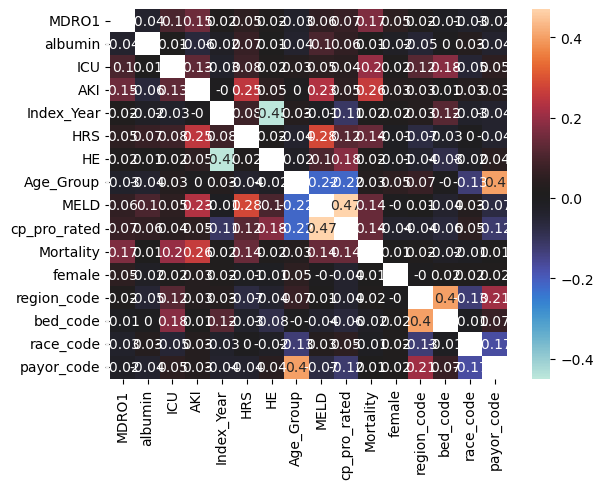

In [19]:
df_corr.corr()
df_corr.unstack().sort_values()

correlation_matrix = df_corr.corr().round(2)
correlation_matrix *= 1 + np.diag(np.nan*np.ones(16))
sns.heatmap(data=correlation_matrix, annot=True, cmap="icefire");

# 3. Logistic Regression

### 3.1 Multivariate

In [20]:
df_2.head()

personid  \
7   0017bb37-317e-41a6-bef7-01b7840fa845   
9   001ef405-5d5f-4625-9836-7a2672f12114   
16  00443f43-e530-41e5-af8a-14140bd6ba68   
20  0078e7c2-2e5c-454e-b8f7-c1624ebdf2d5   
21  007b52cd-8610-483f-b838-d2bfdd803898   

                             encounterid  MDRO1        LOS  albumin  ICU  AKI  \
7   bf6e4e08-dccc-4004-8749-6d9fb4e4f756    0.0   2.626389        1  0.0  1.0   
9   2f0df976-3da1-414e-9d68-f18baeebfa5d    0.0   4.181250        1  0.0  0.0   
16  60fd246e-7745-466a-abe8-052e994b1cf7    0.0   1.904167        1  0.0  0.0   
20  67914502-a5ef-4eda-a88b-4692a376f7bf    1.0  72.888194        1  0.0  1.0   
21  a8aea38c-fe45-4926-bd77-601240987560    0.0  23.989583        1  0.0  1.0   

       Region bed_size  tenant  ...   Age  Age_Group     Race       Payor  \
7        West   >=1000    68.0  ...  55.0        2.0    White    Medicaid   
9        West  500-999    48.0  ...  48.0        1.0  Unknown     Unknown   
16       West   >=1000    63.0  ...  41.0        1.0    White    Medicaid   
20  Northeast  500-999   108.0  ...  60.0        3.0    White  Commercial   
21  Northeast  500-999    31.0  ...  59.0        3.0  Unknown    Medicaid   

    MELD cp_pro_rated Mortality  female  MELD_tertiles  cp_class  
7   18.0     6.000000       1.0       1      Tertile 1         1  
9   28.0    11.000000       0.0       0      Tertile 3         3  
16  24.0    12.000000       0.0       0      Tertile 2         3  
20  16.0    11.000000       0.0       1      Tertile 1         3  
21  19.0     8.333333       0.0       0      Tertile 1         2  

[5 rows x 23 columns]

In [22]:
model = sm.GLM.from_formula("Mortality ~ C(Age_Group, Treatment(reference=2.0)) + \
                                         C(Region, Treatment(reference='West')) + \
                                         C(Index_Year, Treatment(reference=2021)) + \
                                         C(Race, Treatment(reference='White')) + \
                                         C(Payor, Treatment(reference='Medicaid')) + \
                                             HE + HRS + AKI + MDRO1 + albumin + female + ICU + \
                                             C(bed_size, Treatment(reference='>=1000')) + \
                                             C(MELD_tertiles, Treatment(reference='Tertile 1')) + \
                                             C(cp_class, Treatment(reference=1))",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4891
Model Family:                Binomial   Df Model:                           40
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1847.8
Date:                Mon, 14 Oct 2024   Deviance:                       3695.6
Time:                        12:32:30   Pearson chi2:                 4.74e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.1265
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          -3.6201      0.286    -12.663      0.000      -4.180      -3.060
C(Age_Group, Treatment(reference=2.0))[T.1.0]                      -0.2304      0.122     -1.885      0.059      -0.470       0.009
C(Age_Group, Treatment(reference=2.0))[T.3.0]                       0.2299      0.118      1.946      0.052      -0.002       0.461
C(Age_Group, Treatment(reference=2.0))[T.4.0]                       0.3053      0.141      2.171      0.030       0.030       0.581
C(Region, Treatment(reference='West'))[T.Midwest]                   0.4302      0.161      2.667      0.008       0.114       0.746
C(Region, Treatment(reference='West'))[T.Northeast]                 0.2402      0.146      1.643      0.100      -0.046       0.527
C(Region, Treatment(reference='West'))[T.South]                    -0.1047      0.182     -0.574      0.566      -0.462       0.252
C(Index_Year, Treatment(reference=2021))[T.2012.0]                 -0.4628      0.226     -2.051      0.040      -0.905      -0.021
C(Index_Year, Treatment(reference=2021))[T.2013.0]                 -0.3255      0.245     -1.331      0.183      -0.805       0.154
C(Index_Year, Treatment(reference=2021))[T.2014.0]                 -0.4912      0.228     -2.152      0.031      -0.939      -0.044
C(Index_Year, Treatment(reference=2021))[T.2015.0]                 -0.3475      0.214     -1.624      0.104      -0.767       0.072
C(Index_Year, Treatment(reference=2021))[T.2016.0]                 -0.3140      0.204     -1.541      0.123      -0.713       0.085
C(Index_Year, Treatment(reference=2021))[T.2017.0]                 -0.0172      0.180     -0.096      0.924      -0.369       0.335
C(Index_Year, Treatment(reference=2021))[T.2018.0]                 -0.1291      0.161     -0.802      0.422      -0.444       0.186
C(Index_Year, Treatment(reference=2021))[T.2019.0]                 -0.1283      0.144     -0.894      0.371      -0.410       0.153
C(Index_Year, Treatment(reference=2021))[T.2020.0]                 -0.3272      0.157     -2.088      0.037      -0.634      -0.020
C(Index_Year, Treatment(reference=2021))[T.2022.0]                 -0.1441      0.188     -0.768      0.442      -0.512       0.223
C(Race, Treatment(reference='White'))[T.Black]                     -0.1729      0.190     -0.909      0.363      -0.546       0.200
C(Race, Treatment(reference='White'))[T.Other]                      0.0284      0.112      0.253      0.800      -0.191       0.248
C(Race, Treatment(reference='White'))[T.Unknown]                   -0.3566      0.276     -1.291      0.197      -0.898       0.185
C(Payor, Treatment(reference='Medicaid'))[T.Com

### 2.2 Univariate

#### Index Year

In [23]:
model = sm.GLM.from_formula("Mortality ~ C(Index_Year, Treatment(reference=2021))",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4921
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2175.9
Date:                Mon, 14 Oct 2024   Deviance:                       4351.9
Time:                        12:32:46   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002246
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             -1.5559      0.092    -16.848      0.000      -1.737      -1.375
C(Index_Year, Treatment(reference=2021))[T.2012.0]    -0.2483      0.194     -1.280      0.201      -0.629       0.132
C(Index_Year, Treatment(reference=2021))[T.2013.0]    -0.1217      0.208     -0.584      0.559      -0.530       0.287
C(Index_Year, Treatment(reference=2021))[T.2014.0]    -0.3938      0.198     -1.984      0.047      -0.783      -0.005
C(Index_Year, Treatment(reference=2021))[T.2015.0]     0.0308      0.186      0.166      0.868      -0.333       0.394
C(Index_Year, Treatment(reference=2021))[T.2016.0]    -0.2583      0.187     -1.382      0.167      -0.625       0.108
C(Index_Year, Treatment(reference=2021))[T.2017.0]     0.0841      0.162      0.521      0.603      -0.232       0.401
C(Index_Year, Treatment(reference=2021))[T.2018.0]    -0.0298      0.146     -0.204      0.838      -0.316       0.257
C(Index_Year, Treatment(reference=2021))[T.2019.0]    -0.0148      0.132     -0.113      0.910      -0.273       0.243
C(Index_Year, Treatment(reference=2021))[T.2020.0]    -0.2341      0.144     -1.628      0.104      -0.516       0.048
C(Index_Year, Treatment(reference=2021))[T.2022.0]    -0.0989      0.173     -0.573      0.567      -0.437       0.239
======================================================================================================================
"""

#### Age

In [24]:
model = sm.GLM.from_formula("Mortality ~ C(Age_Group, Treatment(reference=2.0))",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4928
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2178.8
Date:                Mon, 14 Oct 2024   Deviance:                       4357.6
Time:                        12:33:05   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001079
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -1.7195      0.078    -22.169      0.000      -1.872      -1.567
C(Age_Group, Treatment(reference=2.0))[T.1.0]    -0.0311      0.111     -0.280      0.779      -0.249       0.186
C(Age_Group, Treatment(reference=2.0))[T.3.0]     0.1589      0.108      1.478      0.139      -0.052       0.370
C(Age_Group, Treatment(reference=2.0))[T.4.0]     0.1654      0.110      1.499      0.134      -0.051       0.382
=================================================================================================================
"""

#### Gender

In [25]:
model = sm.GLM.from_formula("Mortality ~ female",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4930
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2181.4
Date:                Mon, 14 Oct 2024   Deviance:                       4362.7
Time:                        12:33:07   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          4.389e-05
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6603      0.049    -33.828      0.000      -1.757      -1.564
female         0.0371      0.080      0.466      0.641      -0.119       0.193
==============================================================================
"""

#### Race

In [26]:
model = sm.GLM.from_formula("Mortality ~  C(Race, Treatment(reference='White'))",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4928
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2180.0
Date:                Mon, 14 Oct 2024   Deviance:                       4360.0
Time:                        12:33:09   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0006003
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -1.6147      0.046    -35.237      0.000      -1.704      -1.525
C(Race, Treatment(reference='White'))[T.Black]      -0.0402      0.173     -0.233      0.816      -0.379       0.298
C(Race, Treatment(reference='White'))[T.Other]      -0.0917      0.096     -0.953      0.341      -0.280       0.097
C(Race, Treatment(reference='White'))[T.Unknown]    -0.3701      0.256     -1.449      0.147      -0.871       0.131
====================================================================================================================
"""

#### Payor

In [27]:
model = sm.GLM.from_formula("Mortality ~  C(Payor, Treatment(reference='Medicaid'))",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4926
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2180.1
Date:                Mon, 14 Oct 2024   Deviance:                       4360.1
Time:                        12:33:10   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0005670
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -1.6813      0.064    -26.289      0.000      -1.807      -1.556
C(Payor, Treatment(reference='Medicaid'))[T.Commercial]     0.0867      0.110      0.786      0.432      -0.129       0.303
C(Payor, Treatment(reference='Medicaid'))[T.Medicare]       0.0546      0.098      0.557      0.577      -0.137       0.246
C(Payor, Treatment(reference='Medicaid'))[T.Other]         -0.0663      0.218     -0.304      0.761      -0.494       0.361
C(Payor, Treatment(reference='Medicaid'))[T.Self]           0.3375      0.238      1.418      0.156      -0.129       0.804
C(Payor, Treatment(reference='Medicaid'))[T.Unknown]       -0.0184      0.132     -0.139      0.889      -0.277       0.240
===========================================================================================================================
"""

#### Bed Size

In [28]:
model = sm.GLM.from_formula("Mortality ~ C(bed_size, Treatment(reference='>=1000'))",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4926
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2177.2
Date:                Mon, 14 Oct 2024   Deviance:                       4354.5
Time:                        12:33:11   Pearson chi2:                 4.93e+03
No. Iterations:                    19   Pseudo R-squ. (CS):           0.001712
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -1.6153      0.047    -34.534      0.000      -1.707      -1.524
C(bed_size, Treatment(reference='>=1000'))[T.100-199]   -18.9508   1.25e+04     -0.002      0.999   -2.46e+04    2.46e+04
C(bed_size, Treatment(reference='>=1000'))[T.200-299]    -0.3371      0.233     -1.449      0.147      -0.793       0.119
C(bed_size, Treatment(reference='>=1000'))[T.300-499]     0.1112      0.177      0.629      0.530      -0.236       0.458
C(bed_size, Treatment(reference='>=1000'))[T.500-999]    -0.0800      0.093     -0.860      0.390      -0.262       0.102
C(bed_size, Treatment(reference='>=1000'))[T.<100]       -1.2751      0.728     -1.752      0.080      -2.702       0.152
=========================================================================================================================
"""

#### Region

In [29]:
model = sm.GLM.from_formula("Mortality ~ C(Region, Treatment(reference='West'))",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4928
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2179.1
Date:                Mon, 14 Oct 2024   Deviance:                       4358.2
Time:                        12:33:13   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0009558
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -1.6842      0.051    -33.030      0.000      -1.784      -1.584
C(Region, Treatment(reference='West'))[T.Midwest]       0.1379      0.122      1.127      0.260      -0.102       0.378
C(Region, Treatment(reference='West'))[T.Northeast]    -0.0460      0.111     -0.413      0.680      -0.264       0.172
C(Region, Treatment(reference='West'))[T.South]         0.2030      0.112      1.810      0.070      -0.017       0.423
=======================================================================================================================
"""

#### ICU

In [30]:
model = sm.GLM.from_formula("Mortality ~ ICU",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4930
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2097.0
Date:                Mon, 14 Oct 2024   Deviance:                       4194.0
Time:                        12:33:14   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03367
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8922      0.046    -41.443      0.000      -1.982      -1.803
ICU            1.2344      0.091     13.565      0.000       1.056       1.413
==============================================================================
"""

#### HE

In [31]:
model = sm.GLM.from_formula("Mortality ~ HE",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4930
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2180.1
Date:                Mon, 14 Oct 2024   Deviance:                       4360.1
Time:                        12:33:16   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0005688
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6671      0.041    -40.857      0.000      -1.747      -1.587
HE             0.2195      0.129      1.706      0.088      -0.033       0.472
==============================================================================
"""

#### HRS

In [32]:
model = sm.GLM.from_formula("Mortality ~  HRS",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4930
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2137.7
Date:                Mon, 14 Oct 2024   Deviance:                       4275.4
Time:                        12:33:17   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01758
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8575      0.047    -39.584      0.000      -1.949      -1.766
HRS            0.8156      0.085      9.628      0.000       0.650       0.982
==============================================================================
"""

#### MELD

In [33]:
model = sm.GLM.from_formula("Mortality ~ C(MELD_tertiles, Treatment(reference='Tertile 1'))",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4929
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2148.3
Date:                Mon, 14 Oct 2024   Deviance:                       4296.6
Time:                        12:33:19   Pearson chi2:                 4.93e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01335
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          -2.0356      0.073    -27.743      0.000      -2.179      -1.892
C(MELD_tertiles, Treatment(reference='Tertile 1'))[T.Tertile 2]     0.3596      0.101      3.552      0.000       0.161       0.558
C(MELD_tertiles, Treatment(reference='Tertile 1'))[T.Tertile 3]     0.7643      0.095      8.005      0.000       0.577       0.951
===================================================================================================================================
"""

#### CP

In [34]:
model = sm.GLM.from_formula("Mortality ~ C(cp_class, Treatment(reference=1))",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4929
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2144.5
Date:                Mon, 14 Oct 2024   Deviance:                       4289.0
Time:                        12:33:22   Pearson chi2:                 4.93e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01488
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -2.4592      0.217    -11.320      0.000      -2.885      -2.033
C(cp_class, Treatment(reference=1))[T.2]     0.4587      0.228      2.008      0.045       0.011       0.906
C(cp_class, Treatment(reference=1))[T.3]     1.0761      0.222      4.837      0.000       0.640       1.512
============================================================================================================
"""

#### AKI

In [35]:
model = sm.GLM.from_formula("Mortality ~  AKI",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4930
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2005.2
Date:                Mon, 14 Oct 2024   Deviance:                       4010.3
Time:                        12:33:24   Pearson chi2:                 4.93e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06900
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6943      0.084    -32.043      0.000      -2.859      -2.529
AKI            1.6149      0.096     16.888      0.000       1.428       1.802
==============================================================================
"""

#### MDRO

In [36]:
model = sm.GLM.from_formula("Mortality ~ MDRO1",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4930
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2123.0
Date:                Mon, 14 Oct 2024   Deviance:                       4246.0
Time:                        12:33:25   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02344
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8556      0.045    -40.872      0.000      -1.945      -1.767
MDRO1          1.0150      0.090     11.259      0.000       0.838       1.192
==============================================================================
"""

#### Albumin

In [37]:
model = sm.GLM.from_formula("Mortality ~ albumin",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 4932
Model:                            GLM   Df Residuals:                     4930
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2181.3
Date:                Mon, 14 Oct 2024   Deviance:                       4362.7
Time:                        12:33:28   Pearson chi2:                 4.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          5.793e-05
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6770      0.069    -24.143      0.000      -1.813      -1.541
albumin        0.0446      0.084      0.533      0.594      -0.119       0.209
==============================================================================
"""